In [1]:
import os
import openai
import pandas as pd
import logging
from IPython.display import clear_output
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils.utils import log_completion_call, default_arguments_for_openai_completion, ask_gpt, get_feedback, ask_gpt_get_feedback_and_log
from prompts import q2

# setup

In [2]:
def ask_applicant_how_their_approach_works(topic, what_applicant_did):
    prompt = q2.how_it_works_zero_shot.format(topic, what_applicant_did)
    jims_question = ask_gpt_get_feedback_and_log(
        prompt=prompt, 
        topic=topic, 
        args=default_arguments_for_openai_completion, 
        starting_tag='q'
    )
    return jims_question

def answer_applicants_questions_about_task(topic, jims_question, applicants_questions):
    prompt = q2.clarify_applicants_questions.format(topic, jims_question, applicants_questions)
    jims_response = ask_gpt_get_feedback_and_log(
        prompt=prompt, 
        topic=topic, 
        args=default_arguments_for_openai_completion, 
        starting_tag='cq'
    )
    return jims_response

def clarify_questions(topic, jims_question):
    is_question_understood = False
    while is_question_understood == False:
        does_applicant_understand_the_question = input("Do you understand the question? (y/n)")
        if does_applicant_understand_the_question == 'n':
            # allow applicant to ask questions to get clarification
            applicants_questions = input("What questions do you have for the interviewer?")
            # jim responds to applicant's questions
            jims_response = answer_applicants_questions_about_task(topic, jims_question, applicants_questions)
        else:
            break

def validate_applicants_answer(topic, what_applicant_did, applicants_explanation):
    prompt = q2.validate_applicants_answer.format(topic, what_applicant_did, applicants_explanation)
    response = ask_gpt_get_feedback_and_log(
        prompt=prompt, 
        topic=topic, 
        args=default_arguments_for_openai_completion, 
        starting_tag='va'
    )
    validation = response.rsplit("Validation of explanation: ")[-1]
    return validation

def ask_followup_question(topic, what_applicant_did, applicants_answer):
    prompt = q2.ask_followup_question.format(topic, what_applicant_did, applicants_answer)
    response = ask_gpt_get_feedback_and_log(
        prompt=prompt, 
        topic=topic, 
        args=default_arguments_for_openai_completion, 
        starting_tag='fu'
    )
    followup_question = response.rsplit("Jim's follow up question: ")[-1]
    return followup_question

def orchestrate_q1(topic, what_applicant_did):
    jims_question = ask_applicant_how_their_approach_works(topic, what_applicant_did)
    clarify_questions(topic, jims_question)
    applicants_answer = input("Answer: ")
    validation = validate_applicants_answer(topic, what_applicant_did, applicants_answer)
    if validation == 'correct':
        return(1)
    elif validation == 'incorrect':
        return(0)
    elif validation == 'incomplete':
        followup_question = ask_followup_question(topic, what_applicant_did, applicants_answer)
        applicants_answer_to_followup_question = input("Answer: ")
        applicants_full_answer = "{0} {1}".format(applicants_answer, applicants_answer_to_followup_question)
        validation_of_answer_to_followup_question = validate_applicants_answer(topic, what_applicant_did, applicants_full_answer)
        if validation_of_answer_to_followup_question == 'correct':
            return(1)
        elif validation_of_answer_to_followup_question == 'incorrect':
            return(0)


# run

In [3]:
orchestrate_q1(
    topic="model metrics", 
    what_applicant_did="precision"
)
               


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and always applies them correctly.

Jim validates Applicant's answer in the following format:
Problem: $<a data science challenge for Applicant>
What Applicant used: $<the approach Applicant used to solve the problem>
Applicant's explanation: $<applicant's explanation of how Applicant's approach works>
Correct explation: $<correct explanation of how Applicant's approach works>
Validation of explanation: $<whether Applicant's explanation is correct, incomplete, or incorrect>

Below are some correct examples:

Problem: dealing with class imbalance
What Applicant used: undersampled the majority class
Applicant's explanation: By undersampling the majority class, the ratio between the number of observations in the majority and minority classes increases, making the dataset less imbalanced.
Correct explation: By undersampling the majority class, the ratio between the number of observations in

Tag:  
Label:  1
Reason:  
Insights:  


1

In [4]:
orchestrate_q1(
    topic="encoding categorical values", 
    what_applicant_did="one hot encoding"
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and always applies them correctly.

Jim validates Applicant's answer in the following format:
Problem: $<a data science challenge for Applicant>
What Applicant used: $<the approach Applicant used to solve the problem>
Applicant's explanation: $<applicant's explanation of how Applicant's approach works>
Correct explation: $<correct explanation of how Applicant's approach works>
Validation of explanation: $<whether Applicant's explanation is correct, incomplete, or incorrect>

Below are some correct examples:

Problem: dealing with class imbalance
What Applicant used: undersampled the majority class
Applicant's explanation: By undersampling the majority class, the ratio between the number of observations in the majority and minority classes increases, making the dataset less imbalanced.
Correct explation: By undersampling the majority class, the ratio between the number of observations in

Tag:  
Label:  1
Reason:  
Insights:  


1

# todo
- show default tag when accepting user input
- make the printouts make sense
- would it be better to make the q2.py file a json instead?

# issues
- can't quit the chat
- > asking how it works is unreliable
- X validating the how it works question is unreliable
- answer_applicants_questions_about_task is unreliable. It sometimes tells you to answer a different question than "how does this work?". Also, it sometimes gives the answer when it tries to clarify the question.
- validating the applicant's answer is disconnected from the question that has been asked. it may ask "what is the difference between X and Y?" but the validation is for "how does X work?"

## 2 trying to figure out issue with asking how it works

### 2.0 investigating

In [14]:
ask_applicant_how_their_approach_works("model metrics", "precision")


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topi

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [4]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Applicant used: precision
Jim: 
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topi

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [17]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: ${a data science topic}
What Applicant used: ${the approach Applicant used to solve the problem}
Jim: ${a question about how Applicant's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Applicant used: precision
Jim: 
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: ${a data science topic}
What Applicant used: ${the approach Applicant used to solve the problem}
Jim: ${a question about how Applicant's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topi

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [18]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
Jim: 
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
Jim: 
What i

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [19]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
Jim: What ar

Tag:  
Label:  0
Reason:  
Insights:  


'Jim: What are the advantages of using precision as a metric?'

In [5]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Amol used: precision
Jim: How is precision calculated in a machine learning model?


Tag:  
Label:  0
Reason:  
Insights:  


'Jim: How is precision calculated in a machine learning model?'

In [6]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Amol used: precision
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Amol used: precision
Jim: How is precision calculated?


Tag:  
Label:  1
Reason:  
Insights:  


'Jim: How is precision calculated?'

In [7]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Amol used: precision
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Amol for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Amol questions about how the approaches Amol uses work, in the following format:
Topic: ${a data science topic}
What Amol used: ${the approach Amol used to solve the problem}
Jim: ${a question about how Amol's approach works}


Below are some correct examples:

Topic: encoding categorical values
What Amol did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Amol did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Amol used: precision
Jim: How do you calculate precision?

Topic: algorithm selection
What Amol used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Amol used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Amol used: precision
Jim: What is the differe

Tag:  
Label:  0
Reason:  
Insights:  


'Jim: What is the difference between precision and recall?'

- seems to be fixed when i remove the precision example from the prompt. it probably thinks it needs to come up with a different example if one about precision has already been given
- confirming below:

In [8]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Applicant used: precision
Jim: 
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler transforms values?

Topic: model metrics
What Applicant used: precision
Jim: 
What is the difference between preci

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [9]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim: 
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim: 
What is the difference between precision and rec

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

- nope. 

In [10]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim: How is precision calculated?


Tag:  
Label:  1
Reason:  
Insights:  


'Jim: How is precision calculated?'

In [11]:
default_arguments_for_openai_completion

{'model': 'text-davinci-003',
 'temperature': 0,
 'top_p': 1,
 'n': 1,
 'frequency_penalty': 0,
 'presence_penalty': 0,
 'max_tokens': 200}

In [12]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
What is the difference between precision and reca

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [29]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you exp

Tag:  
Label:  1
Reason:  
Insights:  


'What is the formula for calculating precision?'

In [13]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and accuracy?'

In [32]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: algorithm selection
What Applicant used: random fores

Tag:  
Label:  1
Reason:  
Insights:  


'What is the formula for calculating precision?'

In [5]:
ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample 

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [6]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=args, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample 

Tag:  
Label:  0
Reason:  
Insights:  


'What are the differences between precision, recall, and accuracy?'

In [19]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the implications of using precision as a metric for evaluating a model?


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Jim:
""", 
topic='metrics', 
args=args, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What is the relat

Tag:  
Label:  0
Reason:  
Insights:  


'What is the difference between precision and recall?'

In [21]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the implications of using precision as a metric for evaluating a model?


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Jim: Can you explain to me how a standard scaler works?

Below are 10 correct examples when the topic is "model metrics" and What applicant used is "precision":
""", 
topic='metrics', 
args=args, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about how the approaches Applicant uses work, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Jim: $<a question about how Applicant's approach works>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Jim: What is the relat

Tag:  
Label:  0
Reason:  
Insights:  


'Jim: What is precision in the context of model metrics?\n\nJim: How is precision calculated?\n\nJim: What is the mathematical formula for precision?\n\nJim: How is precision different from other model metrics?\n\nJim: What types of problems is precision most effective for?\n\nJim: What are the advantages and disadvantages of using precision?\n\nJim: Is precision a good measure of model performance?\n\nJim: How can precision be improved?\n\nJim: How does precision change as model complexity increases?\n\nJim: What factors affect precision in a model?'

the trick is to mention the question type + give correct and incorrect examples

In [29]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Jim: $<a question about Applicant's approach>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the implications of using precision as a metric for evaluating a model?


Below are some correct examples:

Topic: encoding categorical values
What Applicant did: one-hot encoding
Question type: define
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Question type: define
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Question type: define
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Question type: define
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Question type: define
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Question type: compare
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: pros and cons
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: compare
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: compare
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: compare
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: assumptions
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Question type: pros and cons
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: compare
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: implications
Jim: What are the implications of using precision as a metric for evaluating a model?

Topic: model metrics
What Applicant used: precision
Question type: define
""", 
topic='metrics', 
args=args, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Jim: $<a question about Applicant's approach>

Below are some incorrect examples:

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: definition
Jim: Wha

Tag:  
Label:  1
Reason:  
Insights:  


'Jim: What does precision measure?'

### 2.1 trying feedback loop approach

In [8]:
def validate_jims_question(topic, what_applicant_did, jims_question):
    prompt = q2.validate_jims_question_k_shot.format(topic, what_applicant_did, jims_question)
    gpt_response = ask_gpt_get_feedback_and_log(
        prompt=prompt, 
        topic=topic, 
        args=default_arguments_for_openai_completion, 
        starting_tag='vj'
    )
    is_jims_question_valid = True
    if gpt_response == "Yes":
        is_jims_question_valid = True
    elif gpt_response == "No":
        is_jims_question_valid = False
    return is_jims_question_valid

In [37]:
def ask_applicant_how_their_approach_works_v2(topic, what_applicant_did):
    args = deepcopy(default_arguments_for_openai_completion)
    args['temperature'] = 0.7
    
    jims_question = None
    is_jims_question_valid = False
    while not is_jims_question_valid:
        prompt = q2.how_it_works_zero_shot.format(topic, what_applicant_did)
        jims_question = ask_gpt_get_feedback_and_log(
            prompt=prompt, 
            topic=topic, 
            args=args, 
            starting_tag='q'
        )
        is_jims_question_valid = validate_jims_question(topic, what_applicant_did, jims_question)
        
    return jims_question

In [27]:
ask_applicant_how_their_approach_works_v2(topic='model metrics', 
                                          what_applicant_did='precision')


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and always applies them correctly.

Jim has to validate whether a prospective question is valid. Jim performs the task specified within the <<>>.

Topic: model metrics
What Applicant used: precision
Prospective question: Jim: "Can you explain how precision works and why it may be a preferred metric for this particular model?"
Is question valid: <<whether the question only asks how the approach Applicant chose works. Answer with "Yes" or "No". If the question asks anything other than this, answer "No".>>
Yes


Tag:  
Label:  0
Reason:  
Insights:  


'Jim: "Can you explain how precision works and why it may be a preferred metric for this particular model?"'

# testing if you can fine tune conditional generation tasks by adding a correct/incorrect label to prompts

- this works!

In [56]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Is question correct: $<1 or 0 - whether the question jim asks is of the right type or not>
Jim: $<a question about Applicant's approach>

Below are some examples:

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the implications of using precision as a metric for evaluating a model?

Topic: encoding categorical values
What Applicant did: one-hot encoding
Question type: define
Is question correct: 1
Jim: How does one hot encoding work?

Topic: class imbalance
What Applicant did: downsample the majority class
Question type: define
Is question correct: 1
Jim: How does downsampling work?

Topic: model metrics
What Applicant used: precision
Question type: define
Is question correct: 1
Jim: How do you calculate precision? 

Topic: algorithm selection
What Applicant used: random forest
Question type: define
Is question correct: 1
Jim: How does a random forest model work?

Topic: scaling continuous values
What Applicant used: standard scaler
Question type: define
Is question correct: 1
Jim: Can you explain to me how a standard scaler works?

Topic: model metrics
What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: pros and cons
Is question correct: 1
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the difference between precision and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What are the differences between precision, recall, and accuracy?

Topic: model metrics
What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the relationship between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: assumptions
Is question correct: 1
Jim: What are the assumptions behind the calculation of precision?

Topic: model metrics
What Applicant used: precision
Question type: pros and cons
Is question correct: 1
Jim: What are the advantages and drawbacks of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What are the differences between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: implications
Is question correct: 1
Jim: What are the implications of using precision as a metric for evaluating a model?

Topic: hyper tuning
What Applicant used: gridsearch
Question type: define
Is question correct: 0
Jim: What is the difference between gridsearch and random search?

Topic: hyper tuning
What Applicant used: NA
Question type: define
Is question correct: 0
Jim: Can you explain to me what hyperparameter tuning is?

Topic: hyper tuning
What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

Topic: scaling continuous values
What Applicant used: NA
Question type: define
Is question correct: 0
Jim: What is the purpose of scaling continuous values?

Topic: scaling continuous values
What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

Topic: feature engineering
What Applicant used: NA
Question type: define
Is question correct: 0
Jim: What is feature engineering?

Topic: algorithm selection
What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

Topic: class imbalance
What Applicant did: NA
Question type: define
Is question correct: 0
Jim: What are some techniques to address class imbalance?
""", 
topic='class imbalance', 
args=args, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
Topic: $<a data science topic>
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Is question correct: $<1 or 0 - whether the question jim asks is of the right type or not>
Jim: $<a question about Applicant's approach>

Below are some examples:

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the difference between precision and recall?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the advantages and disadvantages of using precision as a metric?

Topic: model metrics
What Applicant used: precision
Question type: definition
Is question correct:

Tag:  
Label:  1
Reason:  
Insights:  


'Jim: What are some techniques to address class imbalance?'

In [3]:
args = deepcopy(default_arguments_for_openai_completion)
args['temperature'] = 0.7

ask_gpt_get_feedback_and_log(
prompt="""
Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Is question correct: $<1 or 0 - whether the question jim asks is of the right type or not>
Jim: $<a question about Applicant's approach>

Below are some examples:

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What is the difference between precision and recall?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the advantages and disadvantages of using precision as a metric?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What is the difference between precision and accuracy?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the differences between precision, recall, and accuracy?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What is the relationship between precision and recall?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the assumptions behind the calculation of precision?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the advantages and drawbacks of using precision as a metric?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the differences between precision and recall?

What Applicant used: precision
Question type: define
Is question correct: 0
Jim: What are the implications of using precision as a metric for evaluating a model?

What Applicant did: one-hot encoding
Question type: define
Is question correct: 1
Jim: How does one hot encoding work?

What Applicant did: downsample the majority class
Question type: define
Is question correct: 1
Jim: How does downsampling work?

What Applicant used: precision
Question type: define
Is question correct: 1
Jim: How do you calculate precision? 

What Applicant used: random forest
Question type: define
Is question correct: 1
Jim: How does a random forest model work?

What Applicant used: standard scaler
Question type: define
Is question correct: 1
Jim: Can you explain to me how a standard scaler works?

What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the difference between precision and recall?

What Applicant used: precision
Question type: pros and cons
Is question correct: 1
Jim: What are the advantages and disadvantages of using precision as a metric?

What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the difference between precision and accuracy?

What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What are the differences between precision, recall, and accuracy?

What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What is the relationship between precision and recall?

What Applicant used: precision
Question type: assumptions
Is question correct: 1
Jim: What are the assumptions behind the calculation of precision?

What Applicant used: precision
Question type: pros and cons
Is question correct: 1
Jim: What are the advantages and drawbacks of using precision as a metric?

What Applicant used: precision
Question type: compare
Is question correct: 1
Jim: What are the differences between precision and recall?

What Applicant used: precision
Question type: implications
Is question correct: 1
Jim: What are the implications of using precision as a metric for evaluating a model?

What Applicant used: gridsearch
Question type: define
Is question correct: 0
Jim: What is the difference between gridsearch and random search?

What Applicant used: NA
Question type: define
Is question correct: 0
Jim: Can you explain to me what hyperparameter tuning is?

What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

What Applicant used: NA
Question type: define
Is question correct: 0
Jim: What is the purpose of scaling continuous values?

What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

What Applicant used: NA
Question type: define
Is question correct: 0
Jim: What is feature engineering?

What Applicant used: NA
Question type: define
Is question correct: 1
Jim: <<skip>>

What Applicant did: NA
Question type: define
Is question correct: 0
Jim: What are some techniques to address class imbalance?

What Applicant used: gridsearch
Question type: define
Is question correct: 1
""", 
args=default_arguments_for_openai_completion, 
starting_tag='q'
)


Jim is interviewing Applicant for a job as a Data Scientist. Jim knows all concepts in Data Science and is exceptional at applying them correctly.

Jim asks Applicant questions about the approach Applicant uses, in the following format:
What Applicant used: $<the approach Applicant used to solve the problem>
Question type: $<what type of question jim should aks>
Is question correct: $<1 or 0 - whether the question jim asks is of the right type or not>
Jim: $<a question about Applicant's approach>

Below are some examples:

What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the difference between precision and recall?

What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What are the advantages and disadvantages of using precision as a metric?

What Applicant used: precision
Question type: definition
Is question correct: 0
Jim: What is the difference between precision and accuracy?

What Applicant used: precision

Tag:  
Label:  1
Reason:  
Insights:  


'Jim: How does gridsearch work?'

# playing with graphviz

In [1]:
import graphviz

In [2]:
p = graphviz.Graph(name='parent')
p.edge('spam', 'eggs')

c = graphviz.Graph(name='child', node_attr={'shape': 'box'})
c.edge('foo', 'bar')

p.subgraph(c)

In [3]:
print(p.source)

graph parent {
	spam -- eggs
	subgraph child {
		node [shape=box]
		foo -- bar
	}
}



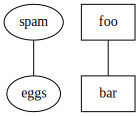

In [4]:
p